In [194]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [218]:
house = pd.read_csv(r"C:\Users\Oscar_On\Downloads\kc_house_data.csv")

In [219]:
house['date'] = house['date'].str[:8]

house['date'] = pd.to_datetime(house['date'], format='%Y%m%d')

# Print the updated DataFrame
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [220]:
# Extract hour, month, day into new columns

house['month'] = house['date'].dt.month

house['day'] = house['date'].dt.day


In [221]:
# Create function to classify quarter
def total_cat(x):
    if x >= 0 and x < 4:
        return 1
    elif x >= 4 and x < 7:
        return 2
    elif x >= 7 and x < 10:
        return 3
    else:
        return 4

In [222]:
house['quarter'] = house['month'].apply(total_cat)

In [205]:
unique_count = house['grade'].nunique()
unique_count

12

In [223]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [201]:
pd.set_option('display.max_columns', None)

house.describe(include="all")

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,day,quarter
count,2.161300e+04,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,2014-10-29 04:38:01.959931648,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,6.574423,15.688197,2.524777
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,1.000000,1.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,4.000000,8.000000,2.000000
50%,3.904930e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,6.000000,16.000000,2.000000
75%,7.308900e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,23.000000,3.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,31.000000,4.000000
std,2.876566e+09,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,3.115308,8.635063,1.034210


In [224]:
# drop column

columns_to_drop = ['lat', 'long', 'id']
house = house.drop(columns_to_drop, axis = 1)

Create testing 1 df

In [208]:
house_test1 = house

In [209]:
# Calculate the IQR for each column
Q1 = house_test1.quantile(0.25)
Q3 = house_test1.quantile(0.75)
IQR = Q3 - Q1

# Define the threshold for outliers
threshold = 1.5

# Create a boolean mask to identify outlier rows for each column
outlier_mask = (house_test1 < (Q1 - threshold * IQR)) | (house > (Q3 + threshold * IQR))

# Drop rows with outliers for all columns
house1_cleaned = house_test1[~outlier_mask.any(axis=1)]

# Reset the index of the cleaned DataFrame
house1_cleaned.reset_index(drop=True, inplace=True)

# Describe the cleaned DataFrame
house1_cleaned.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,month,day,quarter
count,1.507100e+04,15071.000000,15071.000000,15071.000000,15071.000000,15071.000000,15071.0,15071.0,15071.000000,15071.000000,15071.000000,15071.000000,15071.00000,15071.0,15071.000000,15071.000000,15071.000000,15071.000000,15071.000000,15071.000000
mean,4.377983e+05,3.261628,1.972115,1813.719727,7018.010616,1.471137,0.0,0.0,3.418751,7.379471,1586.095216,227.624511,1971.82682,0.0,98079.435738,1796.264415,6898.490810,6.568642,15.713689,2.524053
std,1.798911e+05,0.771481,0.645436,614.489321,3367.154125,0.547325,0.0,0.0,0.646478,0.804137,601.692800,352.498932,29.20239,0.0,53.347959,507.881884,3002.869325,3.125454,8.601838,1.037679
min,8.200000e+04,2.000000,0.750000,560.000000,520.000000,1.000000,0.0,0.0,2.000000,6.000000,480.000000,0.000000,1900.00000,0.0,98001.000000,620.000000,651.000000,1.000000,1.000000,1.000000
25%,3.000000e+05,3.000000,1.500000,1350.000000,4720.000000,1.000000,0.0,0.0,3.000000,7.000000,1140.000000,0.000000,1953.00000,0.0,98033.000000,1420.000000,4800.000000,4.000000,8.000000,2.000000
50%,4.050000e+05,3.000000,2.000000,1740.000000,7068.000000,1.000000,0.0,0.0,3.000000,7.000000,1430.000000,0.000000,1975.00000,0.0,98065.000000,1700.000000,7200.000000,6.000000,16.000000,2.000000
75%,5.450000e+05,4.000000,2.500000,2210.000000,8990.500000,2.000000,0.0,0.0,4.000000,8.000000,1910.000000,440.000000,1999.00000,0.0,98118.000000,2090.500000,8700.000000,9.000000,23.000000,3.000000
max,1.127000e+06,5.000000,3.500000,4200.000000,19141.000000,3.500000,0.0,0.0,5.000000,9.000000,3740.000000,1400.000000,2015.00000,0.0,98199.000000,3640.000000,17550.000000,12.000000,31.000000,4.000000


In [210]:
house1_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15071 entries, 0 to 15070
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15071 non-null  float64
 1   bedrooms       15071 non-null  int64  
 2   bathrooms      15071 non-null  float64
 3   sqft_living    15071 non-null  int64  
 4   sqft_lot       15071 non-null  int64  
 5   floors         15071 non-null  float64
 6   waterfront     15071 non-null  int64  
 7   view           15071 non-null  int64  
 8   condition      15071 non-null  int64  
 9   grade          15071 non-null  int64  
 10  sqft_above     15071 non-null  int64  
 11  sqft_basement  15071 non-null  int64  
 12  yr_built       15071 non-null  int64  
 13  yr_renovated   15071 non-null  int64  
 14  zipcode        15071 non-null  int64  
 15  sqft_living15  15071 non-null  int64  
 16  sqft_lot15     15071 non-null  int64  
 17  month          15071 non-null  int32  
 18  day   

In [211]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  sqft_living15  21613 non-null  int64  
 16  sqft_lot15     21613 non-null  int64  
 17  month          21613 non-null  int32  
 18  day   

Using outlier formula will drop more than 6000 records, which drpos too much.

In [228]:
house_t2 = house

In [229]:
# clean outlier for the price column    

Q1 = house_t2['price'].quantile(0.25)
Q3 = house_t2['price'].quantile(0.75)
IQR = Q3 - Q1

plower_thresold = Q1 - 1.5*IQR
pupper_thresold = Q3 + 1.5*IQR

house_t2 = house.drop(house[house['price'] < plower_thresold].index)

house_t2 = house.drop(house[house['price'] > pupper_thresold].index)

house_t2.reset_index(drop=True, inplace=True)

house_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20467 entries, 0 to 20466
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20467 non-null  datetime64[ns]
 1   price          20467 non-null  float64       
 2   bedrooms       20467 non-null  int64         
 3   bathrooms      20467 non-null  float64       
 4   sqft_living    20467 non-null  int64         
 5   sqft_lot       20467 non-null  int64         
 6   floors         20467 non-null  float64       
 7   waterfront     20467 non-null  int64         
 8   view           20467 non-null  int64         
 9   condition      20467 non-null  int64         
 10  grade          20467 non-null  int64         
 11  sqft_above     20467 non-null  int64         
 12  sqft_basement  20467 non-null  int64         
 13  yr_built       20467 non-null  int64         
 14  yr_renovated   20467 non-null  int64         
 15  zipcode        2046

In [ ]:
numerical_columns = house_t2.select_dtypes(include=['int', 'float']).columns

# Create separate boxplots for numerical columns
for column in numerical_columns:
    plt.figure()  # Create a new figure for each boxplot
    house_t2.boxplot(column=column)
    plt.title(f"Boxplot of {column}")  # Set the title for each boxplot
    plt.show()

In [231]:
house_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20467 entries, 0 to 20466
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20467 non-null  datetime64[ns]
 1   price          20467 non-null  float64       
 2   bedrooms       20467 non-null  int64         
 3   bathrooms      20467 non-null  float64       
 4   sqft_living    20467 non-null  int64         
 5   sqft_lot       20467 non-null  int64         
 6   floors         20467 non-null  float64       
 7   waterfront     20467 non-null  int64         
 8   view           20467 non-null  int64         
 9   condition      20467 non-null  int64         
 10  grade          20467 non-null  int64         
 11  sqft_above     20467 non-null  int64         
 12  sqft_basement  20467 non-null  int64         
 13  yr_built       20467 non-null  int64         
 14  yr_renovated   20467 non-null  int64         
 15  zipcode        2046

In [233]:
# remove outliers for other columns

house_t2 = house_t2.drop(house_t2[house_t2['bedrooms'] > 30].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_living'] > 6000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_lot'] > 0.75*1000000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_above'] > 5000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_basement'] > 2500].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_living15'] > 5000].index)

house_t2 = house_t2.drop(house_t2[house_t2['sqft_lot15'] > 400000].index)

house_t2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20439 entries, 0 to 20466
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20439 non-null  datetime64[ns]
 1   price          20439 non-null  float64       
 2   bedrooms       20439 non-null  int64         
 3   bathrooms      20439 non-null  float64       
 4   sqft_living    20439 non-null  int64         
 5   sqft_lot       20439 non-null  int64         
 6   floors         20439 non-null  float64       
 7   waterfront     20439 non-null  int64         
 8   view           20439 non-null  int64         
 9   condition      20439 non-null  int64         
 10  grade          20439 non-null  int64         
 11  sqft_above     20439 non-null  int64         
 12  sqft_basement  20439 non-null  int64         
 13  yr_built       20439 non-null  int64         
 14  yr_renovated   20439 non-null  int64         
 15  zipcode        20439 non

In [234]:
house_cleaned = house_t2

<Axes: xlabel='sqft_living', ylabel='price'>

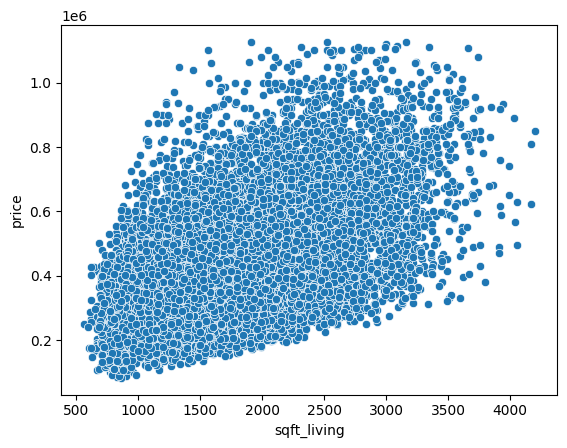

In [235]:
sns.scatterplot(x= 'sqft_living', y= 'price', data= house1_cleaned)

<Axes: xlabel='sqft_living15', ylabel='price'>

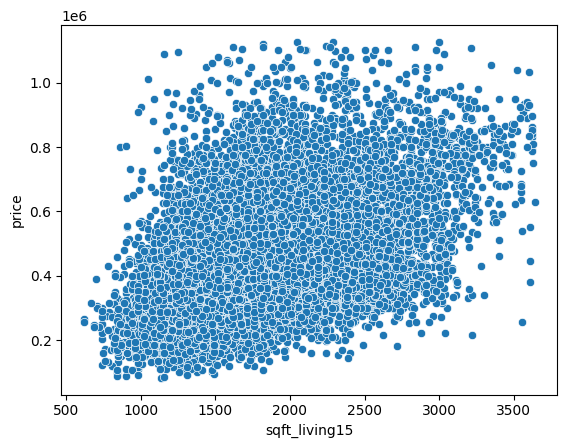

In [239]:
sns.scatterplot(x= 'sqft_living15', y= 'price', data= house1_cleaned)

<Axes: xlabel='sqft_lot', ylabel='price'>

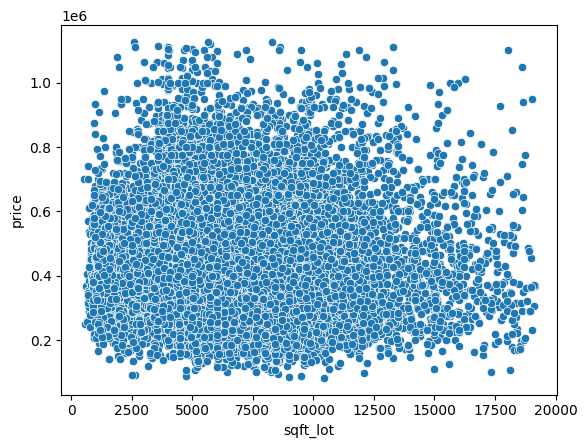

In [237]:
sns.scatterplot(x= 'sqft_lot', y= 'price', data= house1_cleaned)

<Axes: xlabel='sqft_lot15', ylabel='price'>

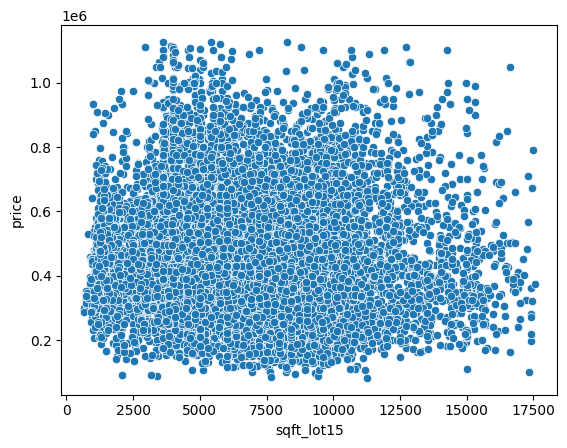

In [238]:
sns.scatterplot(x= 'sqft_lot15', y= 'price', data= house1_cleaned)

In [241]:
results = ols("price ~ sqft_living + sqft_lot+ grade + bedrooms + bathrooms + sqft_living15 + sqft_lot15", data=house_cleaned).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     2572.
Date:                Sun, 09 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:15:38   Log-Likelihood:            -2.7283e+05
No. Observations:               20439   AIC:                         5.457e+05
Df Residuals:                   20431   BIC:                         5.457e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -2.47e+05   9771.028    -25.277

It shows there may have the problem of strong multicollinearity or other numerical problems.

In [244]:
# take logarithm for columns related to sqft and price column 

house_cleaned['log_sqft_living'] = np.log(house_cleaned['sqft_living'])

house_cleaned['log_sqft_living15'] = np.log(house_cleaned['sqft_living15'])

house_cleaned['log_sqft_lot'] = np.log(house_cleaned['sqft_lot'])

house_cleaned['log_sqft_lot15'] = np.log(house_cleaned['sqft_lot15'])

house_cleaned['log_price'] = np.log(house_cleaned['price'])

In [246]:
results = ols("log_price ~ log_sqft_living + log_sqft_lot + grade + bedrooms + bathrooms + log_sqft_living15 + log_sqft_lot15", data=house_cleaned).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     2530.
Date:                Sun, 09 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:22:59   Log-Likelihood:                -6101.1
No. Observations:               20439   AIC:                         1.222e+04
Df Residuals:                   20431   BIC:                         1.228e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.8262      0.07

In [ ]:
results = ols("log_price ~ log_sqft_living + log_sqft_lot + grade + bedrooms + bathrooms + log_sqft_living15 + log_sqft_lot15", data=house_cleaned).fit()
print(results.summary())

In [245]:
house_cleaned.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,month,day,quarter,log_sqft_living,log_sqft_living15,log_sqft_lot,log_sqft_lot15,log_price
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,1340,5650,10,13,4,7.073270,7.200425,8.639411,8.639411,12.309982
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,1690,7639,12,9,4,7.851661,7.432484,8.887653,8.941022,13.195614
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,2720,8062,2,25,1,6.646391,7.908387,9.210340,8.994917,12.100712
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,1360,5000,12,9,4,7.580700,7.215240,8.517193,8.517193,13.311329
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,1800,7503,2,18,1,7.426549,7.495542,8.997147,8.923058,13.142166


In [ ]:
# Get all column names as a list
column_names = house_t2.columns.tolist()


# Combine all column names into a single variable
correlation_matrix = house_t2[column_names].corr()

print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
column_names = house_t2.columns.tolist()
print(column_names)

In [ ]:
results = ols("price ~ sqft_living", data=house_t2).fit()
print(results.summary())

In [ ]:
house_t2_1 = house_t2

In [ ]:
house_t2_1 = house_t2_1[['price', 'sqft_living']]

In [ ]:
house_t2_1.head()

In [ ]:
results = ols("price ~ sqft_living * zipcode", data=house_t2).fit()
print(results.summary())

In [ ]:
house_t2.describe(include = 'all')

In [ ]:
sns.scatterplot(x="sqft_living", y="price", hue="grade", size="grade", data=house_t2)
plt.show()

In [ ]:
house_t2_1.head()

In [ ]:
column_names = house_t2_1.columns.tolist()

In [ ]:
# drop column

columns_to_drop = ['waterfront', 'view', 'zipcode', 'sqft_living15', 'sqft_lot15']
house_t2_1 = house_t2_1.drop(columns_to_drop, axis = 1)

In [ ]:
house_t2_1.head()

In [ ]:
house_t2_1.columns

In [ ]:
daily_dataset = house_t2_1.set_index('date').resample("D").agg({'price': 'mean',
    'bedrooms': 'mean',
    'bathrooms': 'mean',
    'sqft_living': 'mean',
    'sqft_lot': 'mean',
    'floors': 'mean',
    'condition': 'mean',
    'grade': 'mean',
    'sqft_above': 'mean',
    'sqft_basement': 'mean',
    'yr_built': 'mean',
    'yr_renovated': 'mean'})

In [ ]:
daily_dataset.info()

In [ ]:
results = ols("price ~ sqft_living", data=daily_dataset).fit()
print(results.summary())

In [ ]:
house.describe(include='all')

In [ ]:
unique_count = house_t2['zipcode'].nunique()
unique_count